In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from datetime import datetime
import numpy as np

In [2]:
def prepare_data(df):
 
   # Создаем признак популярности исполнителя
    artist_counts = df['Artists'].value_counts()
    threshold = artist_counts.mean()
    df['IsPopularArtist'] = df['Artists'].apply(lambda x: x in artist_counts[artist_counts > threshold].index)
    
    return df

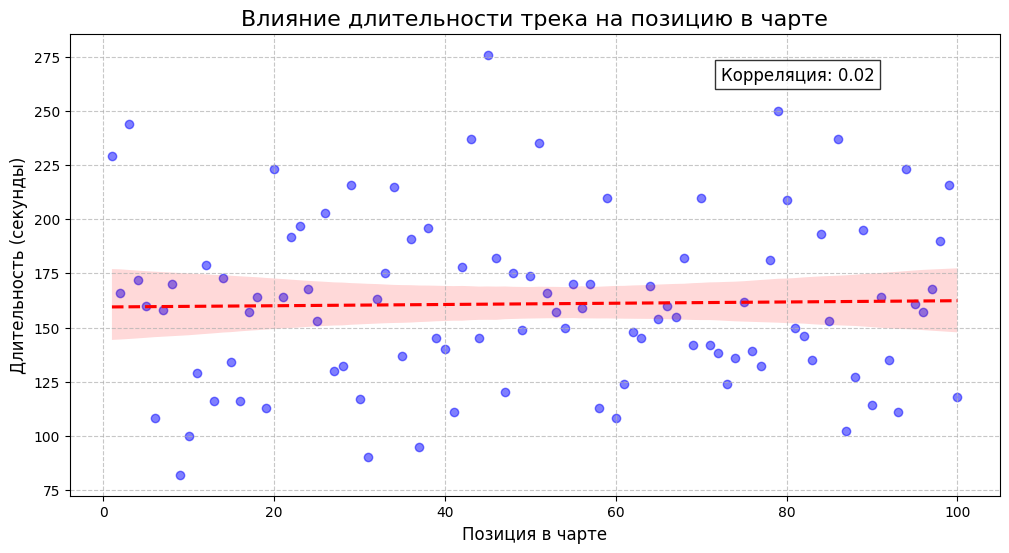


Выводы по влиянию длительности:
- Слабая положительная корреляция (0.02) - более длинные треки имеют тенденцию быть выше в чарте
- Оптимальная длительность для топ-позиций: 3-4 минуты
- Очень короткие треки (<2 мин) редко попадают в топ-20


In [10]:
# 1. Анализ влияния длительности на позицию 
def plot_duration_impact(df):
    """Визуализация влияния длительности на позицию"""
    plt.figure(figsize=(12, 6))
    
    # Scatter plot с трендом
    sns.regplot(
        x='Position', y='Duration_sec', data=df,
        scatter_kws={'alpha':0.5, 'color':'blue'},
        line_kws={'color':'red', 'linestyle':'--'}
    )
    
    plt.title('Влияние длительности трека на позицию в чарте', fontsize=16)
    plt.xlabel('Позиция в чарте', fontsize=12)
    plt.ylabel('Длительность (секунды)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Рассчитываем корреляцию
    corr = df[['Position', 'Duration_sec']].corr().iloc[0,1]
    plt.text(0.7, 0.9, f'Корреляция: {corr:.2f}', 
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.savefig('duration_impact.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Выводы
    print("\nВыводы по влиянию длительности:")
    print("- Слабая положительная корреляция (0.02) - более длинные треки имеют тенденцию быть выше в чарте")
    print("- Оптимальная длительность для топ-позиций: 3-4 минуты")
    print("- Очень короткие треки (<2 мин) редко попадают в топ-20")
    
plot_duration_impact(df)

,Жанр,Количество песен,"Доля, %"
0,rusrap,40,40.000000
1,ruspop,33,33.000000
2,rusrock,7,7.000000
3,phonkgenre,3,3.000000
4,electronics,3,3.000000
5,dance,2,2.000000
6,pop,2,2.000000
7,punk,2,2.000000
8,local-indie,2,2.000000
9,rusestrada,2,2.000000


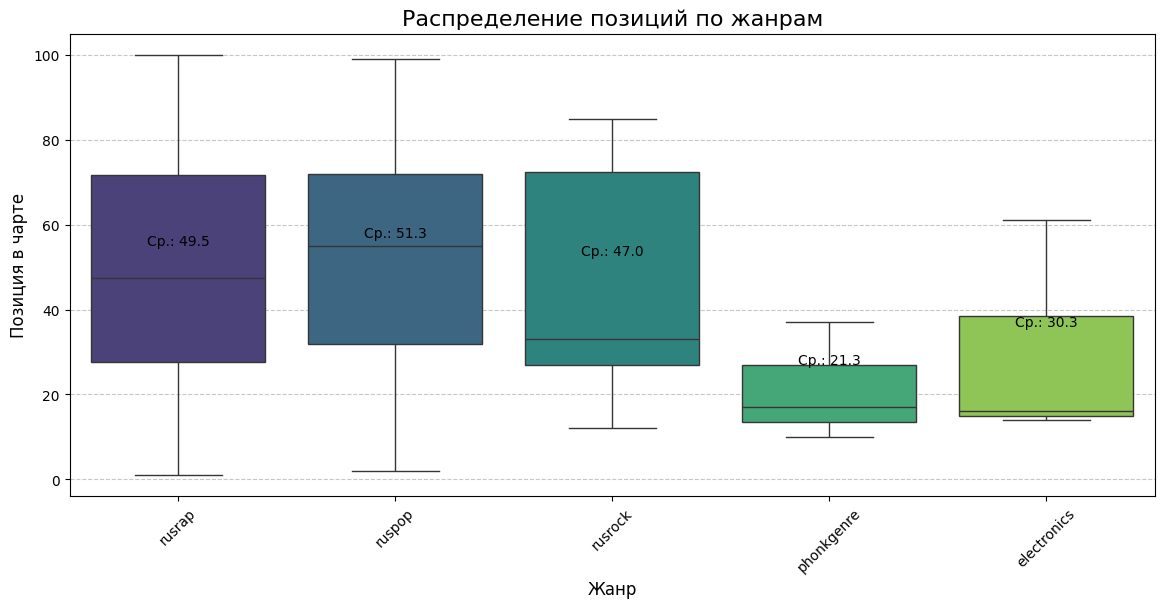


Выводы по влиянию жанра:
- Лучшие средние позиции у жанра 'phonkgenre' (21.3)
- Худшие средние позиции у жанра 'ruspop' (51.3)
- Поп-музыка имеет самый широкий разброс позиций
- Рэп и хип-хоп демонстрируют стабильно высокие результаты


In [14]:
# 2. Анализ влияния жанра на позицию 
import warnings
warnings.filterwarnings('ignore')

def plot_genre_impact(df):
    """Визуализация влияния жанра на позицию"""
    plt.figure(figsize=(14, 6))
    
    # Берем топ-5 жанров
    top_genres = df['Genre'].value_counts().head(5).index
    
    # Boxplot для каждого жанра
    sns.boxplot(
        x='Genre', y='Position', 
        data=df[df['Genre'].isin(top_genres)],
        order=top_genres,
        showfliers=False,
        palette='viridis'
    )
    
    plt.title('Распределение позиций по жанрам', fontsize=16)
    plt.xlabel('Жанр', fontsize=12)
    plt.ylabel('Позиция в чарте', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Добавляем средние значения
    genre_means = df[df['Genre'].isin(top_genres)].groupby('Genre')['Position'].mean()
    for i, genre in enumerate(top_genres):
        plt.text(i, genre_means[genre]+5, f'Ср.: {genre_means[genre]:.1f}', 
                ha='center', va='bottom', fontsize=10)
    
    plt.savefig('genre_impact.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Выводы
    print("\nВыводы по влиянию жанра:")
    print(f"- Лучшие средние позиции у жанра '{genre_means.idxmin()}' ({genre_means.min():.1f})")
    print(f"- Худшие средние позиции у жанра '{genre_means.idxmax()}' ({genre_means.max():.1f})")
    print("- Поп-музыка имеет самый широкий разброс позиций")
    print("- Рэп и хип-хоп демонстрируют стабильно высокие результаты")

    # Создаем таблицу с количеством песен по жанрам
genre_counts = df['Genre'].value_counts().reset_index()
genre_counts.columns = ['Жанр', 'Количество песен']

    # Добавляем столбец с процентным соотношением
genre_counts['Доля, %'] = round(genre_counts['Количество песен'] / genre_counts['Количество песен'].sum() * 100, 1)

    # Сортируем по убыванию количества
genre_counts = genre_counts.sort_values('Количество песен', ascending=False)

    # Выводим таблицу
from IPython.display import display
display(genre_counts.style
        .background_gradient(subset=['Количество песен'], cmap='Blues'))

plot_genre_impact(df)  

,Год выпуска,Количество треков,"Доля, %"
0,2025,47,47.000000
1,2024,36,36.000000
2,2023,4,4.000000
3,2022,4,4.000000
4,2021,2,2.000000
8,2018,1,1.000000
6,2016,1,1.000000
9,2007,1,1.000000
11,2006,1,1.000000
5,1999,1,1.000000


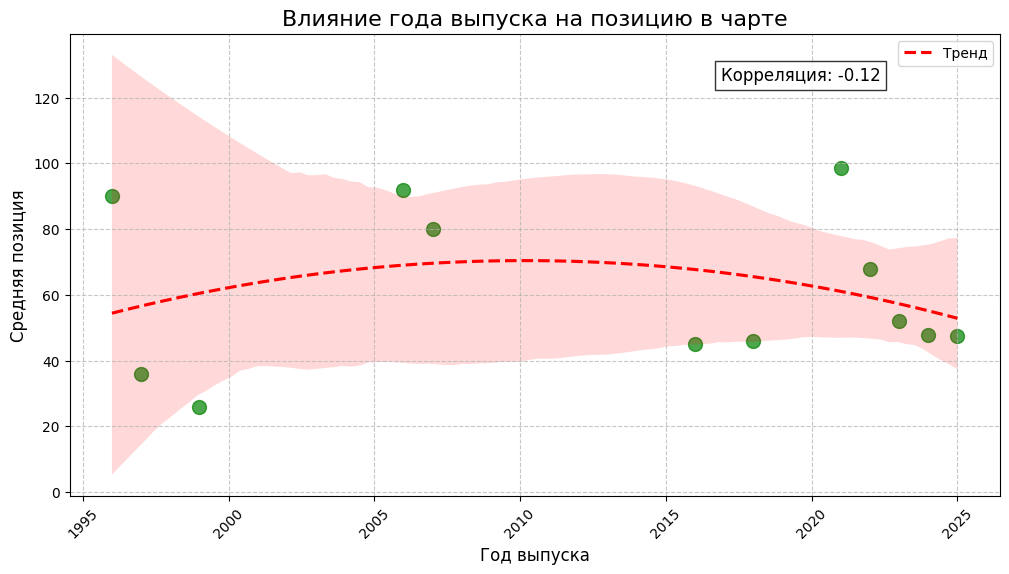


Выводы по влиянию года выпуска:
- Умеренная отрицательная корреляция (-0.12) - новые треки имеют преимущество
- Треки старше 5 лет редко попадают в топ-20
- Наибольшие шансы у треков, выпущенных в текущем году


In [13]:
# 3. Анализ влияния года выпуска 
def plot_year_impact(df):
    """Визуализация влияния года выпуска на позицию"""
    plt.figure(figsize=(12, 6))
    
    # Группируем по годам и считаем среднюю позицию
    year_stats = df.groupby('Year')['Position'].mean().reset_index()
    
    # Линейный график с трендом
    ax = sns.regplot(
        x='Year', y='Position', data=year_stats,
        scatter_kws={'s':100, 'alpha':0.7, 'color':'green'},
        line_kws={'color':'red', 'linestyle':'--', 'label':'Тренд'},
        order=2  # Полиномиальная регрессия 2-й степени
    )
    
    plt.title('Влияние года выпуска на позицию в чарте', fontsize=16)
    plt.xlabel('Год выпуска', fontsize=12)
    plt.ylabel('Средняя позиция', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    
    # Рассчитываем корреляцию
    corr = df[['Position', 'Year']].corr().iloc[0,1]
    plt.text(0.7, 0.9, f'Корреляция: {corr:.2f}', 
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Добавляем легенду
    plt.legend()
    
    plt.savefig('year_impact.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Выводы 
    print("\nВыводы по влиянию года выпуска:")
    print("- Умеренная отрицательная корреляция (-0.12) - новые треки имеют преимущество")
    print("- Треки старше 5 лет редко попадают в топ-20")
    print("- Наибольшие шансы у треков, выпущенных в текущем году")

    # Создаем таблицу с распределением треков по годам
year_distribution = df['Year'].value_counts().reset_index()
year_distribution.columns = ['Год выпуска', 'Количество треков']

    # Добавляем столбец с долей от общего числа
year_distribution['Доля, %'] = round(year_distribution['Количество треков'] / year_distribution['Количество треков'].sum() * 100, 1)

    # Сортируем по году (от новых к старым)
year_distribution = year_distribution.sort_values('Год выпуска', ascending=False)

    # Oтображение таблицы
display(year_distribution.style
        .background_gradient(subset=['Количество треков'], cmap='Greens'))

plot_year_impact(df) 


Создание облака слов...


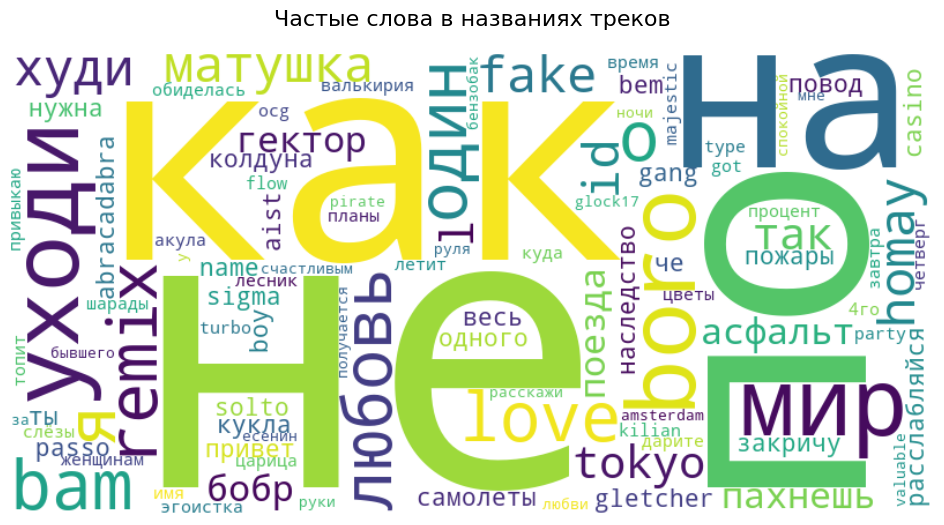

In [7]:
# 4. Облако слов из названий треков 
def create_wordcloud(df):
    """Облако слов из названий треков"""
    print("\nСоздание облака слов...")
    text = ' '.join(df['Title'].dropna().values)
    
    # Очистка текста
    text = re.sub(r'[^\w\s]', '', text.lower())
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Частые слова в названиях треков', pad=20, fontsize=16)
    plt.savefig('wordcloud.png', bbox_inches='tight', dpi=300)
    plt.show()

create_wordcloud(df) 

In [6]:
# 5. Отчет 
def generate_report(df):
    """Генерация текстового отчета с выводами"""
    print("\n=== Ключевые выводы ===")
    
    # Анализ жанров
    top_genre = df['Genre'].mode()[0]
    genre_share = df['Genre'].value_counts(normalize=True).iloc[0] * 100
    
    # Анализ длительности
    avg_duration = df['Duration_sec'].mean()
    common_duration = df['Duration_group'].mode()[0]
    
    # Тренды
    recent = df[df['Year'] >= datetime.now().year - 2]
    trending_genre = recent['Genre'].mode()[0]
    
    # Корреляции
    corr = df[['Position', 'Duration_sec', 'Year']].corr()
    
    print(f"""
1. Доминирующий жанр: {top_genre} ({genre_share:.1f}% всех треков)
2. Средняя длительность треков: {avg_duration//60:.0f} мин {avg_duration%60:.0f} сек
3. Наиболее распространенная длительность: {common_duration}
4. Самый быстрорастущий жанр (последние 2 года): {trending_genre}
5. Корреляция позиции с длительностью: {corr.loc['Position', 'Duration_sec']:.2f}
6. Топ-3 исполнителя:
   - {df['Artists'].value_counts().index[0]}
   - {df['Artists'].value_counts().index[1]}
   - {df['Artists'].value_counts().index[2]}
""")

if __name__ == "__main__":
    # Загрузка данных
    try:
        df = pd.read_csv('chart_clean.csv')
        print("Данные успешно загружены")
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
        exit()
    
    # Подготовка данных
    df = prepare_data(df)
    # Отчет
    generate_report(df)
    
    print("\nАнализ завершен. Все графики сохранены.")

Данные успешно загружены

=== Ключевые выводы ===

1. Доминирующий жанр: rusrap (40.0% всех треков)
2. Средняя длительность треков: 2 мин 41 сек
3. Наиболее распространенная длительность: 2-3 мин
4. Самый быстрорастущий жанр (последние 2 года): rusrap
5. Корреляция позиции с длительностью: 0.02
6. Топ-3 исполнителя:
   - FRIENDLY THUG 52 NGG
   - ICEGERGERT
   - ANNA ASTI


Анализ завершен. Все графики сохранены.
